<a href="https://colab.research.google.com/github/jek97/CNN_for_Image_Recognition/blob/main/ML_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning Project #
## 1. Introduction ##
in this notebok we will create a 8 layer convolutional neural netweork for the image classification of animals.
we build this project using the Keras API, the data is first uploaded ([Dataset](https://www.kaggle.com/datasets/pratik2901/animal-dataset)) and preprocessed, secondly the neural network has been created and feeded with the data, finally the results are analysed.


In [2]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from tqdm import tqdm
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop, SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from tensorflow import keras
from tensorflow.keras import layers


sns.set(style='white', context='notebook', palette='deep')

## 2. Dataset upload and Preprocessing ##


In [3]:
# mount the driver
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# initialize the files path
train_dir='/content/drive/MyDrive/machine learning/dataset/animal_dataset_intermediate/train/'
test_dir='/content/drive/MyDrive/machine learning/dataset/animal_dataset_intermediate/test'

### 2.1 Label Preprocessing ###
the dataset is organized in 5 folders, each one containing the images of a given animal type, the name of such animal is encoded in the direcories name, we can proceed extracting all these labels and associating them to a number.
then we will convert each label number to a hot vector.

In [5]:
# extract the labels from the directories names
Name=[]
for file in os.listdir(train_dir):
    Name+=[file]
print(Name)
print(len(Name))

['elefante_train', 'farfalla_train', 'mucca_train', 'pecora_train', 'scoiattolo_train']
5


In [6]:
# associate a number to each label
N=[]
for i in range(len(Name)):
    N+=[i]
normal_mapping=dict(zip(Name,N))
print(normal_mapping)

{'elefante_train': 0, 'farfalla_train': 1, 'mucca_train': 2, 'pecora_train': 3, 'scoiattolo_train': 4}


### 2.2 Images Preprocessing ###
the colored images are encoded as an array of uniform dimensions of 48 x 48 with normalized valeus of the color components, obtaining a list object of dimension 8196 x 48 x 48 x 3.

In [7]:
# preprocessing of the dataset
trainx0=[]
trainy0=[]
count=0
for file in Name:
    path=os.path.join(train_dir,file)
    for im in tqdm(os.listdir(path)):
        if im[-4:]!='.txt':
            image=load_img(os.path.join(path,im), grayscale=False, color_mode='rgb', target_size=(48,48))
            image=img_to_array(image)
            image=image/255.0 # normalization
            trainx0.append(image)
            trainy0.append(count)
    count=count+1

100%|██████████| 1676/1676 [00:38<00:00, 43.93it/s] 


In [8]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0])
Y_train = to_categorical(trainy0, num_classes = 5)

### 2.3 Dataset Splitting ###
we can devide our dataset in training (70%), validation (20%) and test (10%) sets.

In [9]:
# Set the random seed
random_seed_t = 2
random_seed_v = 4
# Split the train, the validation and the test set for the fitting
X_train, X_ve, Y_train, Y_ve = train_test_split(trainx0, Y_train, test_size = 0.3, random_state=random_seed_t)
X_val, X_test, Y_val, Y_test = train_test_split(X_ve, Y_ve, test_size = 0.33, random_state=random_seed_v)

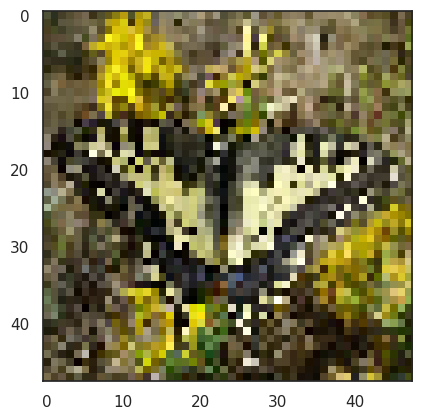

In [10]:
g = plt.imshow(X_train[10][:,:,:])

## 3. CNN Design Training and Testing ##
### 3.1.1 Neural Network Architecture ###
we design the Neural Network taking advantages of the Keras **Sequential** API which is really intuitive and allows to create a sequential NN by adding one layer per time, we started with two **Convolutional** layers that isolate the image features; \
after them a **MaxPool** layer is used to reduce the data sizes by one half, then the first implicit layer, the **Dropout** one, is placed to implicity regularize the model, by randomly set the 30% of the input and output of the neurons to zero. \
the same layers organization is riproposed a second time with different paramethers. \
going forward some layers for the reshape of the data are placed, the **Flatten** layer perform this operation leading to a common shape of all the tensors, while the **Dense** layer perform a matrix multiplication with the same purpose. \
The last Dense layer cover an important role in our architecture since it will shape the data to the size of the hot vector related to the labels and thanks to the softmax activation it will conver the data to a probability distribution of the 5 possible classes.   

In [11]:
# Set the CNN model

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu', input_shape = (48,48,3)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.3))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.35))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(5, activation = "softmax"))
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 24, 24, 64)        36928     
                                                        

### 3.1.2 Optimizer ###
the output of the NN is then used by the optimizer for the training of itself, in detail the **RMSprop** optimizer takes in input the hot vector obtained from the NN and the related true one present in the dataset and evaluate the distance between the two. \
this distance is then used in backpropagation for the tuning of the weights.\
[More informations](https://deepchecks.com/glossary/rmsprop/#:~:text=RMSProp%20algorithm,gradient%20to%20minimize%20the%20loss.)

In [12]:
# Define the optimizer
optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [13]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

### 3.1.3 Learning Rate Reduction ###
commonly used in artificial neural network, the learning rate can be seen as the amount of which the weights are modified respect the error obtained from the optimizer.\
this amount can be changed in case of plateau of the accuracy, in our case, to influence less the weights. \
[More informations](https://machinelearningmastery.com/learning-rate-for-deep-learning-neural-networks/)

In [14]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', # val acc
                                            patience=4,
                                            verbose=1,
                                            factor=0.35,
                                            min_lr=0.00001)

### 3.1.4 Setting the Epochs and the Batch size ###
the model will be trained on many subsection of the dataset composed by a random composition of images (samples) equal to the **batch size**.\
on the other side the **epochs** shows the number of times the whole dataset as been checked by the system during the training.\
You can think of a for-loop over the number of epochs where each loop proceeds over the training dataset. Within this for-loop is another nested for-loop that iterates over each batch of samples, where one batch has the specified “batch size” number of samples. \
[more informations](https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/#:~:text=at%20an%20epoch.-,What%20Is%20an%20Epoch%3F,update%20the%20internal%20model%20parameters.)

In [15]:
# tuning the training
epochs = 30
batch_size = 90

### 3.1.5 Data Augmentation ###
since the dataset dimension is not too big we decided to perform a data augmentation, this operation will take the images, warp and rotate them enlarging their number, this operation will not only increate the dimension of the dataset but also make the final model more robust.

In [16]:
# With data augmentation to prevent overfitting

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180) (it was 10)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)


In [17]:
# Fit the model
history = model.fit_generator(datagen.flow(np.array(X_train),Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (np.array(X_val),Y_val),
                              verbose = 2, steps_per_epoch=np.array(X_train).shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

<ipython-input-17-0e5935407616>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(np.array(X_train),Y_train, batch_size=batch_size),


Epoch 1/30
63/63 - 157s - loss: 1.5873 - accuracy: 0.2908 - val_loss: 1.3499 - val_accuracy: 0.3989 - lr: 0.0010 - 157s/epoch - 2s/step
Epoch 2/30
63/63 - 153s - loss: 1.4490 - accuracy: 0.3976 - val_loss: 1.3745 - val_accuracy: 0.4104 - lr: 0.0010 - 153s/epoch - 2s/step
Epoch 3/30
63/63 - 157s - loss: 1.3028 - accuracy: 0.4569 - val_loss: 1.2270 - val_accuracy: 0.4475 - lr: 0.0010 - 157s/epoch - 2s/step
Epoch 4/30
63/63 - 155s - loss: 1.2378 - accuracy: 0.4905 - val_loss: 1.1802 - val_accuracy: 0.5046 - lr: 0.0010 - 155s/epoch - 2s/step
Epoch 5/30
63/63 - 155s - loss: 1.2168 - accuracy: 0.5043 - val_loss: 1.0627 - val_accuracy: 0.5780 - lr: 0.0010 - 155s/epoch - 2s/step
Epoch 6/30
63/63 - 157s - loss: 1.1227 - accuracy: 0.5394 - val_loss: 1.1763 - val_accuracy: 0.5046 - lr: 0.0010 - 157s/epoch - 2s/step
Epoch 7/30
63/63 - 152s - loss: 1.0940 - accuracy: 0.5564 - val_loss: 0.9880 - val_accuracy: 0.5920 - lr: 0.0010 - 152s/epoch - 2s/step
Epoch 8/30
63/63 - 157s - loss: 1.0608 - accurac

### 3.2.1 Training Considerations ###
The following two graphs will show the performances of the model on the training and validation set at the vary of the epochs during the training.\
this curve cover an important role for the design of the architecture, indeed observing the **Loss curve** as we may expect the training loss decrease, since we are searching for a minima of such function, while the red curve forllow the first, this is a good behavior of our model, if oterwise the two curves would diverge we would recognize: \
1. in case of a validation loss diverging above the training one we would have an **overfitting** situation, where the model is memorizing the training data. \
2. in case of a validation loss diverging below the training one we would have an **underfitting** situation, where the model is taking in consideration only a little part of the information of the dataset. \
Moreover it's important to not exchange the accuracy displayed here for the training and the validation as the real accuracy of the model, intdeed these quantities here are biassed, the final accuracy of the model will be evaluated below.

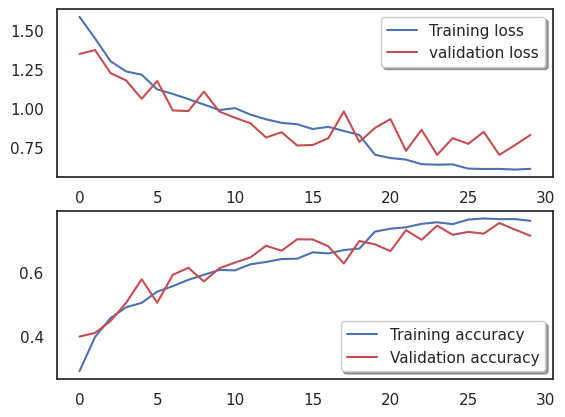

In [18]:
# Plot the loss and accuracy curves for training and validation
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

### 3.3.1 Model Testing ###
once obtained the model we can test it on the test set to evaluate its performances, measuring its accuracy and confuzion matrix.\
indeed while the accuracy of the model is a good paramether to summarize the performance of the model, the confusion matrix gives more clues about the errors, showing which are the animal on which the errors are mainly committed.

In [20]:
# predict results
results = model.predict(np.array(X_test))

# select the indix with the maximum probability
results_classes = np.argmax(results,axis = 1)

# accuracy evaluation
Y_test = np.argmax(Y_test, axis=1)

error = 0
for i in range(len(Y_test)):
  if(Y_test[i] != results_classes[i]):
    error += 1
accuracy = (len(Y_test) - error)/len(Y_test)
print("number of errors: " + str(error))
print("accuracy: " + str(accuracy))
print("global error: " + str((1/accuracy)))

26/26 [==============================] - 6s 225ms/step
number of errors: 234
accuracy: 0.7118226600985221
global error: 1.4048442906574394


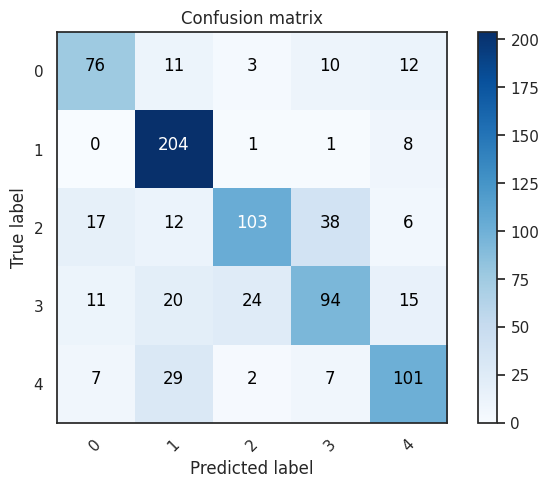

In [22]:
# Look at confusion matrix on testing
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_test, results_classes)
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(5))

52/52 [==============================] - 13s 245ms/step


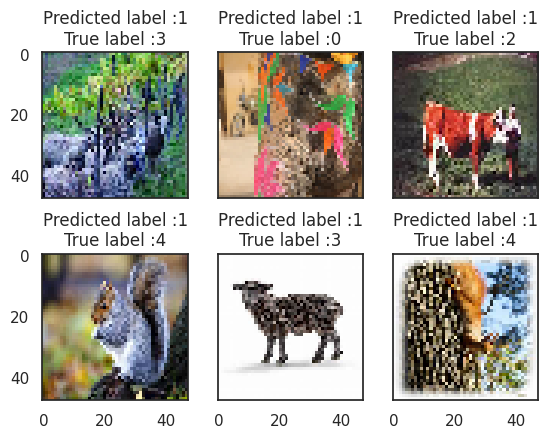

In [24]:
# Display some error results

# Predict the values from the validation dataset
Y_pred = model.predict(np.array(X_val))
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred,axis = 1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1)
# Errors are difference between predicted labels and true labels
errors = (results_classes - Y_test != 0)

Y_pred_classes_errors = results_classes[errors]
Y_pred_errors = results[errors]
Y_true_errors = Y_test[errors]
#X_val1 = np.array(X_val)
X_test_errors = np.array(X_test)[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((48,48,3)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_test_errors, Y_pred_classes_errors, Y_true_errors)